### pixc height smoothing from global to local scale.

In [1]:
import numpy as np
import xarray as xr
from glob import glob
import geopandas as gpd
import matplotlib.pyplot as plt
from utils.functions import pixc_geophy_cor
from utils.swot_data_filter import iter_IQR 
from utils.swot_data_filter import pixc_height_local_filtering


In [2]:
path_lake_vec = 'data/dianchi-lake/hydrolake_dianchi_edit.gpkg'
dir_pixc = 'data/dianchi-lake/swot-pixc'
paths_pixc = sorted(glob(dir_pixc + '/*masked.nc'))  # Get the first .nc file in the directory
print(len(paths_pixc))
paths_pixc[0]


9


'data/dianchi-lake/swot-pixc/SWOT_L2_HR_PIXC_009_049_198L_20240105T211648_20240105T211659_PIC0_01_masked.nc'

In [3]:
## 1. read vector file of the lake.
lake_gdf = gpd.read_file(path_lake_vec)


In [ ]:
pixc_filtered_ds = []
for path_pixc in paths_pixc:
    pixc_nc = xr.open_dataset(path_pixc)
    pixc_ht_filter_ds = pixc_nc[['geoid', 'height']]
    ## 1. geophysical correction for height, and convert to orthometric height
    pixc_ht_cor = pixc_geophy_cor(pixc_nc=pixc_nc)
    pixc_ht_ortho = pixc_ht_cor - pixc_nc.geoid.values
    pixc_ht_filter_ds = pixc_ht_filter_ds.assign({'ht_ortho': (("points",), pixc_ht_ortho)})
    pixc_ht_filter_ds.ht_ortho.attrs['description'] = 'PIXC height data with geophysical correction and orthometric correction (use geoid variable)'

    ## 2. height filtering 
    ## 2.1 height filtering in global region using IQR method
    pixc_ht_ortho_filter1, IQR = iter_IQR(pixc_ht_ortho, IQR_thre=0.3, iter_max=5)
    pixc_ht_ortho_filter1 = pixc_ht_ortho_filter1.filled(np.nan)
    pixc_ht_filter_ds = pixc_ht_filter_ds.assign({'ht_ortho_filter1': (("points",), pixc_ht_ortho_filter1)})
    pixc_ht_filter_ds.ht_ortho_filter1.attrs['description'] = 'PIXC height data with global filtering using IQR method'

    ## 2.2 height filtering in local region
    pixc_ht_ortho_filter2 = pixc_height_local_filtering(pixc_height=pixc_ht_ortho_filter1, 
                                              pixc_lonlat=(pixc_nc.longitude.values, pixc_nc.latitude.values), 
                                              thre=0.2, 
                                              radius_m=500)
    pixc_ht_filter_ds = pixc_ht_filter_ds.assign({'ht_ortho_filter2': (("points",), pixc_ht_ortho_filter2)})
    pixc_ht_filter_ds.ht_ortho_filter2.attrs['description'] = 'PIXC height with both global and local filtering'
    pixc_ht_filter_ds = pixc_ht_filter_ds.assign({'ht_valid_ids': (("points",), ~np.isnan(pixc_ht_ortho_filter2))})
    pixc_ht_filter_ds.ht_valid_ids.attrs['description'] = 'PIXC height indices of valid data'
    # # 3. save the filtered data
    path_pixc_filtered = path_pixc.replace('.nc', '_filtered.nc')
    pixc_ht_filter_ds.to_netcdf(path_pixc_filtered, mode='w', format='NETCDF4')  ## save the filtered data
    print(f'Filtered data saved to: {path_pixc_filtered}')


Filtered data saved to: data/dianchi-lake/swot-pixc/SWOT_L2_HR_PIXC_009_049_198L_20240105T211648_20240105T211659_PIC0_01_masked_filtered.nc
Filtered data saved to: data/dianchi-lake/swot-pixc/SWOT_L2_HR_PIXC_010_049_198L_20240126T180154_20240126T180205_PIC0_01_masked_filtered.nc
Filtered data saved to: data/dianchi-lake/swot-pixc/SWOT_L2_HR_PIXC_012_049_198L_20240308T113203_20240308T113214_PIC0_01_masked_filtered.nc
Filtered data saved to: data/dianchi-lake/swot-pixc/SWOT_L2_HR_PIXC_014_049_198L_20240419T050213_20240419T050224_PIC0_01_masked_filtered.nc
Filtered data saved to: data/dianchi-lake/swot-pixc/SWOT_L2_HR_PIXC_016_049_198L_20240530T223221_20240530T223232_PIC0_01_masked_filtered.nc
Filtered data saved to: data/dianchi-lake/swot-pixc/SWOT_L2_HR_PIXC_018_049_198L_20240711T160229_20240711T160240_PIC0_01_masked_filtered.nc
Filtered data saved to: data/dianchi-lake/swot-pixc/SWOT_L2_HR_PIXC_019_049_198L_20240801T124734_20240801T124745_PIC0_02_masked_filtered.nc
Filtered data saved 

In [5]:
print(np.nanstd(pixc_ht_filter_ds['ht_ortho']))
print(np.nanstd(pixc_ht_filter_ds['ht_ortho_filter1']))
print(np.nanstd(pixc_ht_filter_ds['ht_ortho_filter2']))


79.4187
0.1302129
0.10632979


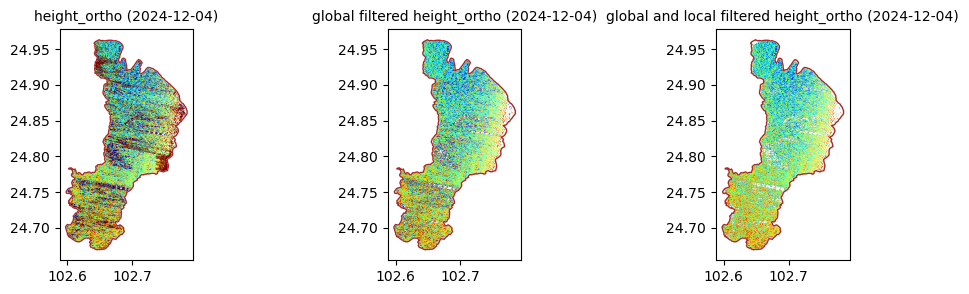

In [7]:
height_median = np.nanmedian(pixc_ht_filter_ds['ht_ortho_filter2'])
heights = [pixc_ht_filter_ds['ht_ortho'], 
           pixc_ht_filter_ds['ht_ortho_filter1'], 
           pixc_ht_filter_ds['ht_ortho_filter2']]
ax_title = ['height_ortho', 
              'global filtered height_ortho', 
              'global and local filtered height_ortho']
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for i in range(3):
  scat1 = ax[i].scatter(x=pixc_ht_filter_ds.longitude, 
                            y=pixc_ht_filter_ds.latitude, 
                            c=heights[i], s=0.1, 
                            vmin=height_median-0.3, vmax=height_median+0.3,
                            edgecolor='none', cmap='jet')
  lake_gdf.plot(ax=ax[i], edgecolor='Brown', facecolor='none', linewidth=1)
  ax[i].set_title(f'{ax_title[i]} ({pixc_ht_filter_ds.attrs["date"]})', fontsize=10)


Text(0.5, 1.0, 'Height Distribution')

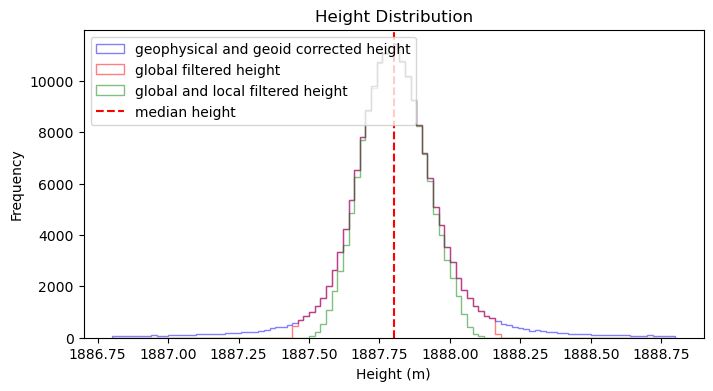

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(pixc_ht_filter_ds['ht_ortho'], bins=100, color='blue', 
            range=(height_median-1, height_median+1),histtype='step',
            alpha=0.5, label='geophysical and geoid corrected height');
ax.hist(pixc_ht_filter_ds['ht_ortho_filter1'], bins=100, color='red', 
            range=(height_median-1, height_median+1), histtype='step',
            alpha=0.5, label='global filtered height');
ax.hist(pixc_ht_filter_ds['ht_ortho_filter2'], bins=100, color='green', 
            range=(height_median-1, height_median+1), histtype='step',
            alpha=0.5, label='global and local filtered height');
ax.axvline(height_median, color='red', linestyle='--', label='median height');
ax.legend(fontsize=10, loc ='upper left')
ax.set_xlabel('Height (m)')
ax.set_ylabel('Frequency')
ax.set_title('Height Distribution')
